# Documenting the "edge effect" in distance calculations based on a topic model

Working with measures of "novelty" and "transience" based on KL divergence, I noticed that these had a tendency to peak toward the center of a timeline. I was originally working with a two-century model (1800-2009), but if I subdivided the original data to model a one-century timeline (1900-2009), I *still* got a peak in the center of the timeline.

Conversation with Laure Thompson and David Mimno led me to think more about the mechanism causing this. To get more confirmation I wanted to try another model (1800-1914)--but also (maybe more importantly) a different measure of distance. KLD distance measures are a little weird and asymmetrical. What about good old cosine distance?

The data I'm using is mostly distributed evenly across time (200 vols a year). But there's a big exception to this before 1840, where data is quite a bit sparser. That should be kept in mind as you scan the graphs below.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import glob, math
from scipy.stats import pearsonr, zscore, ttest_ind
from statistics import mean, stdev
from math import sqrt

## Patterns in a model 1800-1914

To get the data we need to first concatenate a lot of summary files. These distances are calculated with volume-against volume comparisons, which ... given 20,000 volumes in this model ... gets to be enough computation that I wanted to distribute it across a cluster. Thus the separate files of results.

In [2]:
paths = glob.glob('../19results/*summary.tsv')
paths

['../19results/19thseg2500summary.tsv',
 '../19results/19thseg0summary.tsv',
 '../19results/19thseg15000summary.tsv',
 '../19results/19thseg17500summary.tsv',
 '../19results/19thseg12500summary.tsv',
 '../19results/19thseg10000summary.tsv',
 '../19results/19thseg5000summary.tsv',
 '../19results/19thseg7500summary.tsv']

In [3]:
dfs = []
for p in paths:
    df = pd.read_csv(p, sep = '\t', index_col = 'docid')
    dfs.append(df)
    print(df.shape)

data = pd.concat(dfs, verify_integrity = True)
print(data.shape)

(2500, 27)
(2500, 27)
(2500, 27)
(2142, 27)
(2500, 27)
(2500, 27)
(2500, 27)
(2500, 27)
(19642, 27)


#### get some metadata so we can enrich our data with date of publication

In [4]:
meta = pd.read_csv('../meta/filtered19csample.tsv', sep = '\t', index_col = 'docid')

In [5]:
data = data.join(meta.inferreddate, how = 'inner')

#### now look at measures based on KL divergence

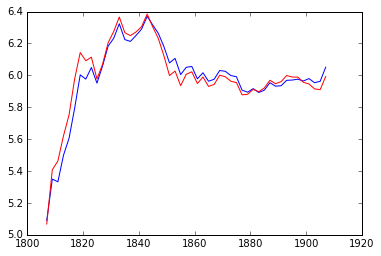

In [6]:
novmeans = []
transmeans = []
years = []

resmeans = []
for floor in range(1800, 1920, 2):
    df = data.loc[(data.inferreddate > floor) & (data.inferreddate < floor + 9), : ]
    nas = np.isnan(df['resonance_1.0_10'])
    novmeans.append(np.mean(df['novelty_1.0_10'][~nas]))
    transmeans.append(np.mean(df['transience_1.0_10'][~nas]))
    years.append(floor + 5)
    
plt.plot(years, novmeans)
plt.plot(years, transmeans, color = 'r')
plt.show()

This is the first time we're not seeing a 100% straightforward "novelty mountain" in the middle of the timeline. **But note** I think there may be reasons for that. Here's the "novelty" trajectory I calculated using straightforward tf-idf vectors so they wouldn't be distorted by the edge-sampling effects of a topic model.

![title](../images/idfvecnovelty20window.png)

If you think carefully you can see how that real trajectory, overlaid on a "novelty mountain," might produce the variant we're seeing in the image above. The real rise circa 1905 could cancel out the spurious drop-off caused by edge sampling effects.

## Let's look at cosine distance.

I calculated cosine distances as the average of all this-volume-to-other-volume comparisons looking ten years backward from this volume, and (separately) looking ten years forward.

In [7]:
paths = glob.glob('../19results/*cosines.tsv')
paths

['../19results/19thseg10000cosines.tsv',
 '../19results/19thseg12500cosines.tsv',
 '../19results/19thseg7500cosines.tsv',
 '../19results/19thseg5000cosines.tsv',
 '../19results/19thseg2500cosines.tsv',
 '../19results/19thseg0cosines.tsv',
 '../19results/19thseg17500cosines.tsv',
 '../19results/19thseg15000cosines.tsv']

In [8]:
dfs = []
for p in paths:
    df = pd.read_csv(p, sep = '\t', index_col = 'docid')
    dfs.append(df)
    print(df.shape)

cosines = pd.concat(dfs, verify_integrity = True)
print(cosines.shape)

(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2142, 2)
(2500, 2)
(19642, 2)


In [9]:
cosines = cosines.join(meta.inferreddate, how = 'inner')

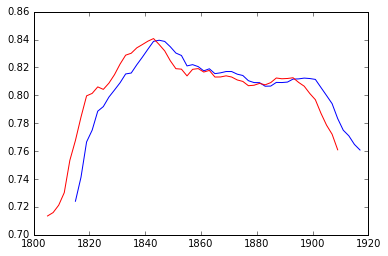

In [10]:
backwardmeans = []
forwardmeans = []
cosyears = []

for floor in range(1800, 1920, 2):
    df = cosines.loc[(cosines.inferreddate > floor) & (cosines.inferreddate < floor + 9), : ]
    if floor > 1809:
        nas = np.isnan(df['backward'])
        backwardmeans.append(np.mean(df['backward'][~nas]))
    else:
        backwardmeans.append(np.nan)
    
    if floor < 1905:
        nas = np.isnan(df['forward'])
        forwardmeans.append(np.mean(df['forward'][~nas]))
    else:
        forwardmeans.append(np.nan)
        
    cosyears.append(floor + 5)
    
plt.plot(cosyears, backwardmeans)
plt.plot(cosyears, forwardmeans, color = 'r')
plt.show()

That's a variant of Novelty Mountain. Let's call it, um, Cosine Plateau.

## What does Cosine Plateau look like if we model a longer timeline?

In [11]:
paths = glob.glob('../unifiedresults/*cosines.tsv')
paths

['../unifiedresults/unified20000cosines.tsv',
 '../unifiedresults/unified32500cosines.tsv',
 '../unifiedresults/unified22500cosines.tsv',
 '../unifiedresults/unified30000cosines.tsv',
 '../unifiedresults/unified10000cosines.tsv',
 '../unifiedresults/unified0cosines.tsv',
 '../unifiedresults/unified2500cosines.tsv',
 '../unifiedresults/unified12500cosines.tsv',
 '../unifiedresults/unified7500cosines.tsv',
 '../unifiedresults/unified17500cosines.tsv',
 '../unifiedresults/unified15000cosines.tsv',
 '../unifiedresults/unified5000cosines.tsv',
 '../unifiedresults/unified27500cosines.tsv',
 '../unifiedresults/unified35000cosines.tsv',
 '../unifiedresults/unified25000cosines.tsv',
 '../unifiedresults/unified37500cosines.tsv']

In [12]:
dfs = []
for p in paths:
    df = pd.read_csv(p, sep = '\t', index_col = 'docid')
    dfs.append(df)
    print(df.shape)

unicos = pd.concat(dfs, verify_integrity = True)
print(unicos.shape)

(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(2500, 2)
(1956, 2)
(39456, 2)


In [13]:
unimeta = pd.read_csv('../meta/unifiedsample.tsv', sep = '\t', index_col = 'docid')

In [14]:
unicos = unicos.join(unimeta.earliestdate, how = 'inner')

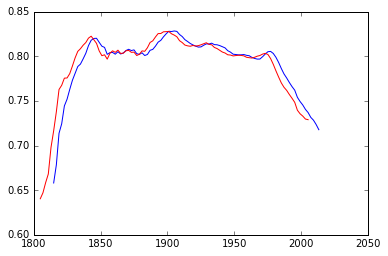

In [15]:
backwardmeans = []
forwardmeans = []
cosyears = []

for floor in range(1800, 2010, 2):
    df = unicos.loc[(unicos.earliestdate > floor) & (unicos.earliestdate < floor + 9), : ]
    if floor > 1809:
        nas = np.isnan(df['backward'])
        backwardmeans.append(np.mean(df['backward'][~nas]))
    else:
        backwardmeans.append(np.nan)
    
    if floor < 2001:
        nas = np.isnan(df['forward'])
        forwardmeans.append(np.mean(df['forward'][~nas]))
    else:
        forwardmeans.append(np.nan)
        
    cosyears.append(floor + 5)
    
plt.plot(cosyears, backwardmeans)
plt.plot(cosyears, forwardmeans, color = 'r')
plt.show()

The walls of the plateau are steeper here, which is interesting. It's like the effect has a fixed temporal radius. I'm trying to think if this could be caused by some kind of thresholding error in my code, but not coming up with anything.

I know the results would be unreliable if we got less than 10 years away from the edge (because you wouldn't have a ten year window to calculate). But that's why I've built in those if-then statements to NaN out stuff less than 10 yrs from an edge.

## What if we test our original hypotheses using cosine distance?

In [16]:
unicos.head()

,backward,forward,earliestdate
docid,,,
hvd.hwtqwj,NaN,0.767489,1800
nyp.33433075724116,NaN,0.645649,1800
nyp.33433075724090,NaN,0.628122,1800
uiuo.ark+=13960=t8pc3pr08,NaN,0.556675,1800
uiuo.ark+=13960=t9572451c,NaN,0.592809,1800


In [17]:
unicos = unicos.assign(diff = unicos.backward - unicos.forward)

In [19]:
suppmeta = pd.read_csv('../supplement1/lastnamesupp1meta.tsv', sep = '\t', index_col = 'docid')
prestdata = unicos.join(suppmeta.tags, how = 'inner')
prestdata.shape

(1263, 5)

In [22]:
elitecol = prestdata.loc[prestdata.tags == 'elite', 'diff']
elitemask = np.isnan(elitecol)
vulgarcol = prestdata.loc[prestdata.tags == 'vulgar', 'diff']
vulgarmask = np.isnan(vulgarcol)
t, p = ttest_ind(elitecol[~elitemask], 
                 vulgarcol[~vulgarmask])
print("t-test", t, p)
a = elitecol[~elitemask]
b = vulgarcol[~vulgarmask]
cohens_d = (mean(a) - mean(b)) / (sqrt((stdev(a) ** 2 + stdev(b) ** 2) / 2))
print("Cohen's d", cohens_d)
print() 

t-test 6.46651669206 1.45186318543e-10
Cohen's d 0.371629842164



The effect is plenty significant. Not *quite* as significant as you get using the methods in Barron et al. 2018, but plenty significant.